In [1]:
import pandas as pd
from glob import glob
from tqdm import tqdm
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LassoCV
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE 
import seaborn as sns

rng = np.random.default_rng(None)

In [2]:
def dataset_from_files(folder='generated_sims/*', file_to_save='sims_counts_dataset.parquet'):
    
    dataset = []
    for file in tqdm(glob(folder)):
        try:
            data = pd.read_parquet(file)
            status_counts = data.groupby('week')['status']\
                                .value_counts().unstack(level=1)

            status_counts['sim_number'] = file.split('_')[2]\
                                              .replace('.parquet', '')
            action = data.groupby('week')['action'].apply(
                                                    lambda x: x.unique()[0])\
                                                   .reset_index()
            df = pd.merge(status_counts, action, on='week')    
            dataset.append(df.reset_index(drop=True))
        except:
            print(file)
            os.remove(file)
            
        
    cc_dataset = pd.concat(dataset)
    cc_dataset = cc_dataset.rename(columns = {
                                          -1 : 'removed',
                                           0 : 'susceptible',
                                           1 : 'exposed',
                                           2 : 'infected',
                                           3 : 'hospitalized'
                                         })
    cc_dataset.to_parquet(file_to_save)
    return cc_dataset

In [3]:
#dataset = dataset_from_files()
dataset = pd.read_parquet('sims_counts_dataset.parquet')
dataset = dataset.fillna(0)
dataset['sim_id'] = dataset['sim_number']

In [4]:
values = ['removed', 'susceptible', 'exposed', 'infected', 'hospitalized']

total = dataset[values].sum(axis=1)
for c in values:
    dataset[c] = dataset[c] / total

In [5]:
shifts = []
for i in range(1,5):
    shifted = dataset.groupby('sim_number').shift(i)
    shifted['week'] = shifted['week'] + i
    shifted = shifted.reset_index(drop=True)
    shifted.columns = pd.Series(shifted.columns).apply(lambda x: x if x in ['week', 'sim_id'] else x+'_'+str(i))
    shifts.append(shifted)

In [6]:
df = dataset.copy()
for shift in shifts:
    df = pd.merge(df, shift, on=['sim_id', 'week'])

In [7]:
unique_ids = df.sim_id.unique()
train = rng.choice(unique_ids, size=int(len(unique_ids)*0.7), replace=False)
test = [uid for uid in unique_ids if uid not in train]

train_df = df[df['sim_id'].isin(train)].drop(columns=['sim_number', 'sim_id'])
test_df = df[df['sim_id'].isin(test)].drop(columns=['sim_number', 'sim_id'])

train_df.shape, test_df.shape

((13294, 31), (5750, 31))

In [8]:
action_cols = [c for c in train_df.columns if 'action' in c]
train_df = pd.get_dummies(train_df, columns=action_cols)
test_df = pd.get_dummies(test_df, columns=action_cols)

In [9]:
X_train = train_df.drop(columns=['removed', 'susceptible', 'exposed', 'infected', 'hospitalized'])
#X_train = train_df.drop(columns=['hospitalized'])
y_train = train_df['hospitalized']

X_test = test_df.drop(columns=['removed', 'susceptible', 'exposed', 'infected', 'hospitalized'])
y_test = test_df['hospitalized']


In [10]:
reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
reg.score(X_train, y_train)

0.11864023642487276

In [11]:
pred = reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.000029


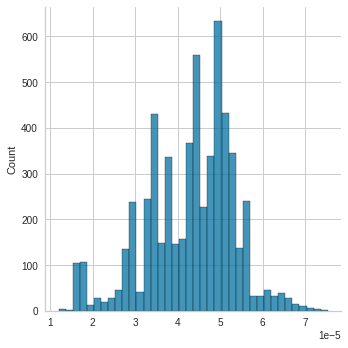

In [12]:
sns.displot(pred)

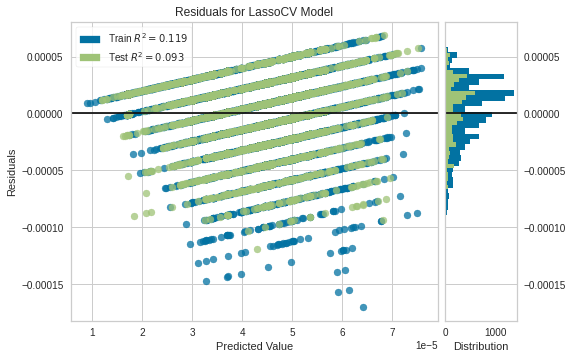

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [13]:

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
act_cols = [c for c in X_train.columns if 'action' in c]

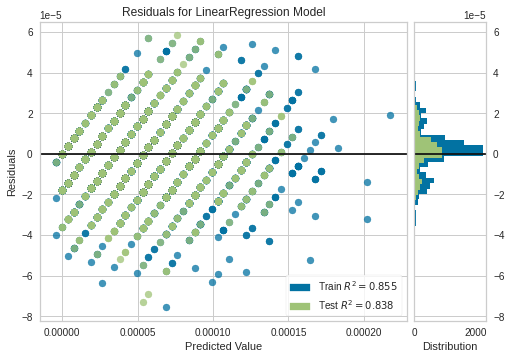

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [16]:
reg = LinearRegression()
act_cols = [c for c in X_train.columns if 'action' in c] + ['week']
X_train_noact = X_train.drop(columns=act_cols)
X_test_noact = X_test.drop(columns=act_cols)

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train_noact, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_noact, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

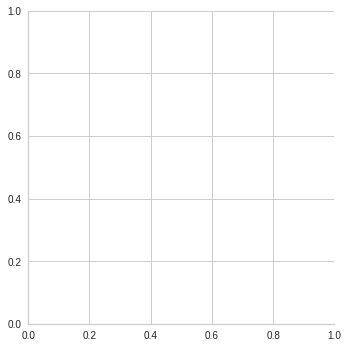

In [17]:
sns.displot()

In [18]:
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.000015


In [19]:
y_test.mean()

4.135652926077868e-05

In [20]:
from sklearn.metrics import r2_score
r2_score(y_test, pred)

0.7563084748702438

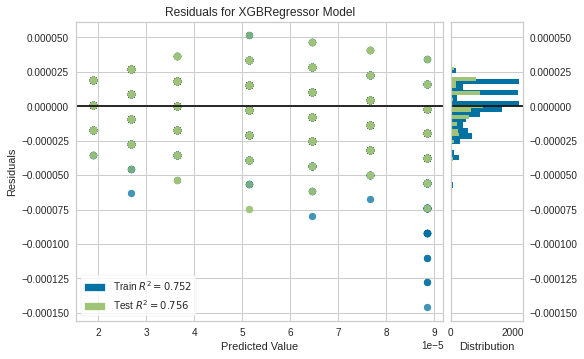

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [21]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_train_noact, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_noact, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

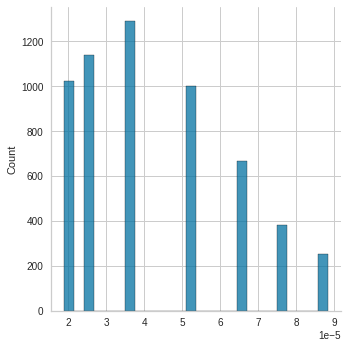

In [22]:
import seaborn as sns
sns.displot(pred)

In [24]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()

In [38]:
scaler = scaler.fit(X_train_noact)

In [39]:
X_sc_train = scaler.transform(X_train_noact)
X_sc_test = scaler.transform(X_test_noact)

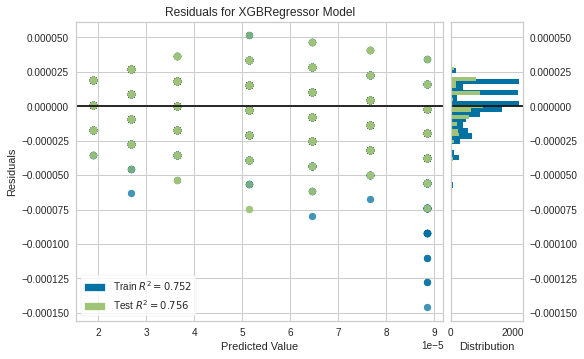

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [40]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_sc_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_sc_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [43]:
np.unique(xgb_r.predict(X_sc_test))

array([1.8906083e-05, 2.6854759e-05, 3.6496698e-05, 5.1357340e-05,
       6.4573040e-05, 7.6497068e-05, 8.8379376e-05], dtype=float32)

In [47]:
y_train.value_counts()

0.000036    2854
0.000018    2625
0.000054    2519
0.000000    2018
0.000072    1679
0.000090     836
0.000108     454
0.000126     199
0.000144      60
0.000162      33
0.000180      12
0.000198       2
0.000216       2
0.000234       1
Name: hospitalized, dtype: int64

In [44]:
np.unique(y_test)

array([0.00000000e+00, 1.80206156e-05, 3.60412312e-05, 5.40618468e-05,
       7.20824623e-05, 9.01030779e-05, 1.08123694e-04, 1.26144309e-04,
       1.44164925e-04, 1.62185540e-04])